In [135]:
import numpy as np
from numpy import polyfit, poly1d
import os
import pandas as pd
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import time
import matplotlib.pyplot as plt
import copy


In [150]:
def interpolate_pupil(data, shi=20):
    data['LeftPupilD'][data['LeftPupilD']<1.5] = np.nan
    data['RightPupilD'][data['RightPupilD']<1.5] = np.nan
    data = data.interpolate(method='linear',axis=0,limit_direction ='both')
    data.dropna(axis=0)
    data_s = SG_fil(data,shi+1,2)
    return data_s

def SG_fil(data,shi,order=2):
    df = data.copy()
    column_name = df.columns.tolist()
    df_new = pd.DataFrame(columns=column_name)
    for n in column_name:
        df_new[n] = savgol_filter(df.loc[:,n],shi,order)
    return df_new  

def func_curve(x, a, b, c):
    return a * np.exp(b * x) + c

In [157]:
data_path = '../../data/images/black_white/'
data_collection = ['LeftPupilD','RightPupilD','Lumin']
data=[]
data_not_interpolate = []
print(os.listdir(data_path))
for file_path in os.listdir(data_path):
    t=pd.read_csv(data_path+file_path,index_col=0)
    data_not_interpolate.append(t[data_collection])
    t = interpolate_pupil(t[data_collection])
    t.index = range(len(t))
    t.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
    data.append(t[data_collection])
data_delete = copy.deepcopy(data)



['test1018_HMD.csv', 'test_lumin_xpp_1_HMD.csv', 'test_lumin_xpp_2_HMD.csv', 'test_lumin_yy_1_HMD.csv', 'test_lumin_yy_2_HMD.csv', 'test_lumin_zty_1_HMD.csv', 'test_lumin_zty_2_HMD.csv']


d:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
d:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
d:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

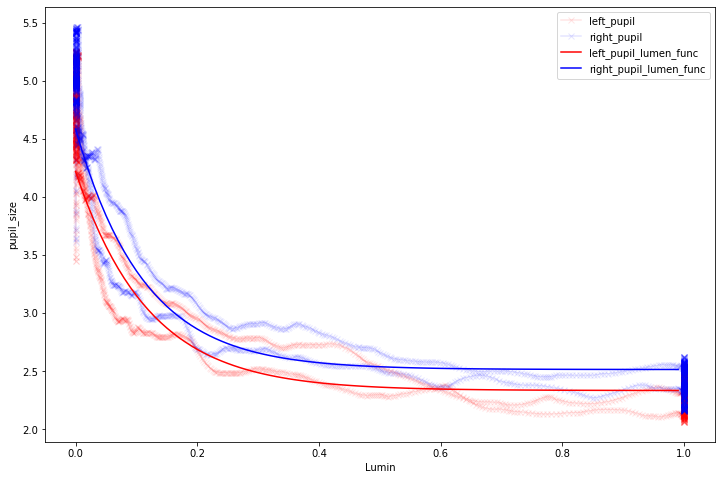

(array([ 1.88383458, -8.36050151,  2.33437216]), array([[ 2.90757159e-04, -5.35060460e-04, -8.96836725e-05],
       [-5.35060460e-04,  4.41957225e-02, -1.46220873e-03],
       [-8.96836725e-05, -1.46220873e-03,  1.25516579e-04]]))
(array([ 2.06898292, -8.915426  ,  2.51500334]), array([[ 3.01083066e-04, -6.45606956e-04, -8.58699345e-05],
       [-6.45606956e-04,  4.22451839e-02, -1.37624081e-03],
       [-8.58699345e-05, -1.37624081e-03,  1.21257133e-04]]))


In [170]:
# for test, choose which file
data_index = 5
# start frame
start = 100
# end frame
end = len(data[data_index][['Lumin']].values)-100
# lumin times adjustion
multi_lumin = 1

data_delete = copy.deepcopy(data)
# equation matching
data_delete[data_index]['LeftPupilD'][data_delete[data_index]['Lumin'] < 0.0001*multi_lumin] = np.nan
data_delete[data_index]['RightPupilD'][data_delete[data_index]['Lumin'] < 0.0001*multi_lumin] = np.nan
data_delete[data_index]['Lumin'][data_delete[data_index]['Lumin'] < 0.0001*multi_lumin] = np.nan
data_delete[data_index]['LeftPupilD'][data_delete[data_index]['Lumin'] > 0.9999*multi_lumin] = np.nan
data_delete[data_index]['RightPupilD'][data_delete[data_index]['Lumin'] > 0.9999*multi_lumin] = np.nan
data_delete[data_index]['Lumin'][data_delete[data_index]['Lumin'] > 0.9999*multi_lumin] = np.nan
data_delete[data_index] = data_delete[data_index].dropna(axis=0)

x_lumin = data_delete[data_index][['Lumin']][start:end].values.ravel()*multi_lumin
x_lumin[x_lumin == 0] = 0.00001
left_original_pupil = data_delete[data_index][['LeftPupilD']][start:end].values.ravel()
right_original_pupil = data_delete[data_index][['RightPupilD']][start:end].values.ravel()
coeff_left = curve_fit(func_curve, x_lumin, left_original_pupil)
coeff_right = curve_fit(func_curve, x_lumin, right_original_pupil)

# plot original data
plt.figure(figsize=(12, 8))
plt.plot(data[data_index][['Lumin']][start:end].values*multi_lumin, data[data_index][['LeftPupilD']][start:end].values, label='left_pupil', c='r',marker='x', alpha=0.1)
plt.plot(data[data_index][['Lumin']][start:end].values*multi_lumin, data[data_index][['RightPupilD']][start:end].values, label='right_pupil', c='b',marker='x', alpha=0.1)

x = np.arange(0,1,0.01)
plt.plot(x, coeff_left[0][0] * np.exp(coeff_left[0][1] * x) + coeff_left[0][2], label='left_pupil_lumen_func', c='r')
plt.plot(x, coeff_right[0][0] * np.exp(coeff_right[0][1] * x) + coeff_right[0][2], label='right_pupil_lumen_func', c='b')

plt.xlabel("Lumin")
plt.ylabel("pupil_size")
plt.legend()
plt.show()
print(coeff_left)
print(coeff_right)

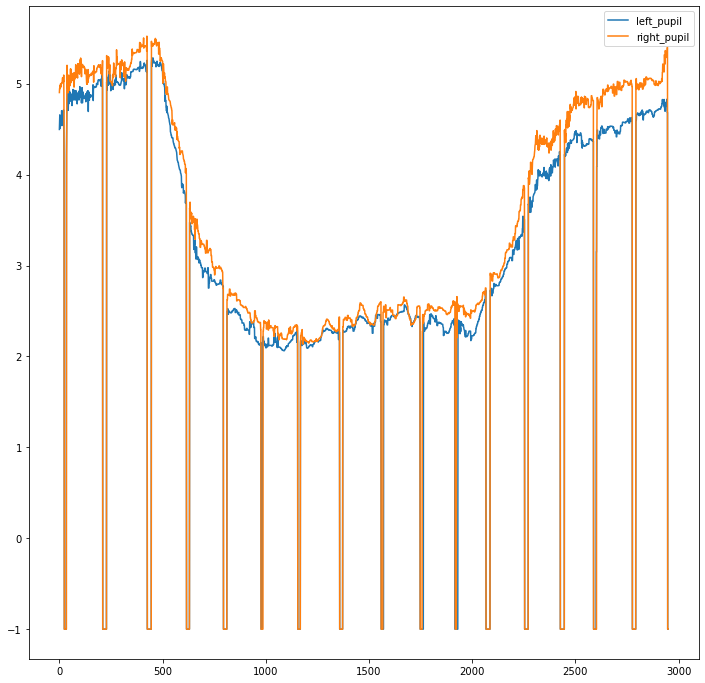

In [171]:
def exp_func(coeff,x):
    y = coeff[0][0] * np.exp(coeff[0][1] * x) + coeff[0][2]
    return y


x_lumin = data[data_index][['Lumin']][start:end].values.ravel()*multi_lumin
left_original_pupil = np.array(data_not_interpolate[data_index][['LeftPupilD']][start:end]).ravel()
right_original_pupil = np.array(data_not_interpolate[data_index][['RightPupilD']][start:end]).ravel()
left_adjust_pupil = exp_func(coeff_left,x_lumin).ravel()
right_adjust_pupil = exp_func(coeff_right,x_lumin).ravel()
left_cogload = np.array(data[data_index][['LeftPupilD']][start:end]).ravel() - left_adjust_pupil
right_cogload = np.array(data[data_index][['RightPupilD']][start:end]).ravel() - right_adjust_pupil
plt.figure(figsize=(12, 12))
plt.plot(left_original_pupil, label='left_pupil')
plt.plot(right_original_pupil, label='right_pupil')
# plt.plot(left_adjust_pupil, label='left_lumin_adj')
# plt.plot(right_adjust_pupil, label='right_lumin_adj')
# plt.plot(left_cogload, label='left_lumin_final')
# plt.plot(right_cogload, label='right_lumin_final')
# plt.plot(x_lumin*5, label='lumin*5')

plt.legend()
plt.show()